In [100]:
from pathlib import Path
import json
import pandas as pd
import numpy as np
from IPython.display import display, HTML
from datetime import datetime
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from functools import reduce
from statistics import mean

In [101]:
def extractCosts(jsonfiles):
    costs = {}
    for f in jsonfiles:
        instance = f['config']['instance']
        costs[instance] = []
        for expl in f['results']['expl_seq']:
            costs[instance].append(expl['cost'])
        
    return costs

In [102]:
def plotCosts(ousCosts, musCosts, figsize, coeff_thick = 8):
#     plt.figure(figsize=figsize)
 
    sizes = []
    x = []
    y = []
    for k in ousCosts:
        # minlen = min(len(ousCosts[k]), len(musCosts[k]))
        x1 = ousCosts[k]
        y1 = musCosts[k]
        x+= x1
        y += y1
    
    d = {}
    for xi,yi in zip(x, y):
        if (xi, yi) in d:
            d[(xi, yi)] += coeff_thick
        else:
            d[(xi, yi)] = coeff_thick

    xplot = [] 
    yplot = []
    splot = []  
    for ((xi, yi), si) in d.items():
        xplot.append(xi)
        yplot.append(yi)
        splot.append(si)
    plt.scatter(xplot, yplot, s=splot)
#         # allCosts.append((x1, y1))
    # Plot formatting
    plt.plot(range(0, 400, 1) , range(0, 400, 1), linestyle='--')
    # plt.xlim((0, 50))
    plt.xlabel('OUS Explanation cost')
    plt.ylabel('MUS Explanation cost')
#     plt.title(instance + " - " + col)
#     plt.title("Comparison OUS/MUS Explanation cost", fontsize=20)
    plt.savefig('/home/crunchmonster/Desktop/figs/experiemnt5_qualitative_'+ datetime.now().strftime("%Y%m%d%H%M%S%f.jpg"), optimize=True, bbox_inches='tight')
    plt.savefig('/home/crunchmonster/Documents/VUB/01_SharedProjects/03_holygrail/latex/conferences/ijcai21/figures/'+ "rq1.png", optimize=True, bbox_inches='tight')
    plt.savefig('/home/crunchmonster/Documents/VUB/01_SharedProjects/03_holygrail/latex/conferences/ijcai21/figures/'+ "rq1.jpg", optimize=True, bbox_inches='tight')
    plt.savefig('/home/crunchmonster/Documents/VUB/01_SharedProjects/03_holygrail/latex/conferences/ijcai21/figures/'+ "rq1.pdf", bbox_inches='tight')
    plt.show()


In [103]:
def list_json_dir(folder):
    p = Path(folder)

    # list files in dir
    files = [f for f in p.iterdir() if f.suffix == '.json']
    return files

def read_json(f_path):
    with f_path.open('r') as fp:
        json_dict = json.load(fp)
        
        json_dict.update({'fname':f_path.name})
        
    return json_dict

In [104]:
def plot_instance_post(df, instance, col):
    
    if instance:
        df_inst_col = df[df['instance'] == instance][['#expl','config', col, 'totTime']]
    else:
        df_inst_col = df[['#expl','config', col, 'totTime']]

    df_inst_col['x'] = df_inst_col[col].apply(lambda x: [i for i in range(1, len(x) + 1)])
    df_inst_col = df_inst_col.sort_values(by=['#expl','totTime'], ascending=[False, True])

    plt.figure(figsize=(30,15))
    for i, row in df_inst_col.iterrows():
        print(row)
        plt.plot(row['x'], row[col], label=row['config'])
        
    # Plot formatting
    plt.legend(fontsize=20, loc='upper left')
    plt.xlim((0, 20))
    plt.ylim((0, 2000))
    plt.xlabel('Number of explanation steps', fontsize=20)
    plt.ylabel('Execution time (s) - timeout [7200s]', fontsize=20)
    plt.title("Title")
    
    plt.show()


In [105]:
import matplotlib.pyplot as plt

# Origin problem
def plot_instance_col(df, instance, col):
    if instance:
        df_inst_col = df[df['instance'] == instance][['#expl','config', col, 'totTime']]
    else:
        df_inst_col = df[['#expl','config', col, 'totTime']]
#     print(df_inst_col)
    df_inst_col['x'] = df_inst_col[col].apply(lambda x: [i for i in range(1, len(x) + 1)])
    df_inst_col = df_inst_col.sort_values(by=['#expl','totTime'], ascending=[False, True])

    plt.figure(figsize=(30,30))
    for i, row in df_inst_col.iterrows():
        plt.plot(row['x'], row[col], label=row['config'])
        
    # Plot formatting
    plt.legend(fontsize=20)
    # plt.xlim((0, 50))
    plt.xlabel('Number of explanation steps', fontsize=20)
    plt.ylabel('Execution time (s) - timeout [7200s]', fontsize=20)
#     plt.title(instance + " - " + col)
    plt.title("Title")
    plt.savefig('/home/crunchmonster/Desktop/figs/'+ datetime.now().strftime("%Y%m%d%H%M%S%f.jpg"), optimize=True, bbox_inches='tight')
    plt.show()


In [106]:
def groupByConfWithReduce(df, selectedConfigFilters, title, fact='cumul-ous'):
    allconfigKeys = ['preseeding', 'sat-polarity', 'sat-polarity-initial', 'postpone_opt', 'postpone_opt_incr', 'postpone_opt_greedy', 'grow', 'grow_sat', 'grow_subset_maximal', 'grow_maxsat', 'maxsat_polarities', 'grow_maxsat_full_pos', 'grow_maxsat_full_inv', 'grow_maxsat_full_unif', 'grow_maxsat_initial_pos', 'grow_maxsat_initial_inv', 'grow_maxsat_initial_unif', 'grow_maxsat_actual_pos', 'grow_maxsat_actual_unif', 'grow_maxsat_actual_inv']
    groupKeys = [key for key in allconfigKeys if key not in selectedConfigFilters]
    dfgrouped = df.groupby(by=groupKeys)[fact].apply(list).reset_index(name=fact)
    # display(dfgrouped)
    dfgrouped[fact] = dfgrouped[fact] \
                                .apply(lambda x: sorted(reduce(lambda a,b: a + b, x))) \
                                .apply(lambda x: list(filter(lambda elem: elem > 0, x)))

    mapping = {
        'preseeding':'pre!',
        'sat-polarity': 'sat-pol',
        'sat-polarity-initial': 'sat-pol-ini',
        'postpone_opt': 'post',
        'postpone_opt_incr': 'p_incr',
        'postpone_opt_greedy': 'p_greedy',
        'grow': 'grow',
        'grow_sat': 'g_sat',
        'grow_subset_maximal': 'g_subset',
        'grow_maxsat': 'g_maxsat',
        'maxsat_polarities': '_maxsatpols_',
        'grow_maxsat_full_pos': 'max_full_pos',
        'grow_maxsat_full_inv': 'max_full_inv',
        'grow_maxsat_full_unif': 'max_full_unif',
        'grow_maxsat_initial_pos': 'max_init_pos',
        'grow_maxsat_initial_inv': 'max_ini_inv',
        'grow_maxsat_initial_unif': 'max_ini_pos',
        'grow_maxsat_actual_pos': 'max_actual_pos',
        'grow_maxsat_actual_unif': 'max_actual_unif',
        'grow_maxsat_actual_inv': 'max_actual_inv',
    }
    dfgrouped['config'] = dfgrouped.apply(
        lambda x: reduce(lambda a, b: a + (mapping[b]+'_' if x[b] else ''), [field for field in groupKeys if field not in [fact] and x[field]] , ""),
        axis = 1
    )
    dfgrouped['x'] = dfgrouped.apply(lambda x: list(range(len(x[fact])) ), axis=1 )
    dfgrouped['len'] = dfgrouped.apply(lambda x: len(x[fact]), axis=1 )
    for (i, row) in dfgrouped.sort_values(by ='len', ascending=False).iterrows():
        print(row)
    dfgrouped.sort_values(by ='len', ascending=False)
    # display(dfgrouped[['x','cumul-ous']])
    mStyles = [".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_",0,1,2,3,4,5,6,7,8,9,10,11]
    mStyles = mStyles * 10
    plt.figure(figsize=(80,40))
    for ((i, row), marker) in zip(dfgrouped.sort_values(by ='len', ascending=False).iterrows(), mStyles):
        plt.plot(row['x'], row[fact], label=row['config'], marker=marker )
    plt.legend(fontsize=20)
    plt.xlabel('Explanation steps ordered', fontsize=20)
    plt.xlim((0, 5000))
    plt.ylabel('Time!', fontsize=20)
    plt.title(title, fontsize=20)
    plt.grid(True)
    plt.savefig('/home/crunchmonster/Desktop/figs/experiment4'+ datetime.now().strftime("%Y%m%d%H%M%S%f.pdf"), optimize=True, bbox_inches='tight')
    dfgrouped.to_json('/home/crunchmonster/Desktop/json/experiment4'+ '_' + title+ '_'+ datetime.now().strftime("%Y%m%d%H%M%S%f.json"))
    dfgrouped.to_csv('/home/crunchmonster/Desktop/json/experiment4'+ '_' + title+ '_'+ datetime.now().strftime("%Y%m%d%H%M%S%f.csv"))
    plt.show()


In [107]:
def jsonFilesToPandasDF(json_files):
    timeoutTime = 7200
    pd_dict = {
        # running parameters
        'timedout':[],
        'config':[],
        'cumul-ous': [],
        'cumul-sat':[],
        'cumul-post':[],
        'cumul-opt':[],
        'cumul-HS': [],
        'cumul-HS-all': [],
        'totTime': [],
        'timeToFirst': [],
        'First-Tot': [],
        'fname':[],
        'created':[],
        'maxsat_polarities':[],
        'disableConstrained':[]
    }

    config_mapping = {
            'preseeding': 'pre',
            'preseeding-grow': 'pre-grow',
            'sat-polarity':'satpol',
            'sat-polarity-initial': 'satpol-ini',
            'postpone_opt_incr':'incr',
            'postpone_opt_greedy':'greedy',
            'grow_subset_maximal':'subset-max',
            'grow_sat':'grow_sat',
            'grow_maxsat_full_unif':"MaxSat-A-unif",
            'grow_maxsat_full_pos':"MaxSat-A-pos",
            'grow_maxsat_full_inv': "MaxSat-A-inv",
            'grow_maxsat_initial_pos': "MaxSat-I0-pos", 
            'grow_maxsat_initial_inv':  "MaxSat-I0-inv", 
            'grow_maxsat_initial_unif': "MaxSat-I0-unif", 
            'grow_maxsat_actual_pos':  "MaxSat-Icur-pos",  
            'grow_maxsat_actual_unif': "MaxSat-Icur-unif", 
            'grow_maxsat_actual_inv': "MaxSat-Icur-inv",
            'maxsat_polarities': "maxsat_polarities"
    }
    

    for f_json in json_files:
        for k, v in f_json['config'].items():
            if k not in pd_dict:
                pd_dict[k] = []
            pd_dict[k].append(v)
        for k, v in f_json['results'].items():
            if k == 'timeout':
                pd_dict['timedout'].append(v)
                continue
            if k not in pd_dict:
                pd_dict[k] = []
            pd_dict[k].append(v)
        if 'maxsat_polarities' not in f_json['config']:
            pd_dict["maxsat_polarities"].append(False)
        if 'disableConstrained' not in f_json['config']:
            pd_dict['disableConstrained'].append(False)
        pd_dict['fname'].append(f_json['fname'])
        
        pd_dict['created'].append(datetime.strptime(f_json['fname'].split('_')[1].replace('.json',''), '%Y%m%d%H%M%S%f'))

        add_configs = [f_json['config']['instance'] if f_json['config']['instance'] != 'origin-problem' else 'puzzle']

        for k,v in f_json['config'].items():
            if v == True and k in config_mapping:
                add_configs.append(config_mapping[k])

        if pd_dict['timedout']:
            pd_dict['totTime'].append(timeoutTime)
                
        pd_dict['config'].append('_'.join(add_configs))
        if 'OUS-time' in f_json['results']: 
            pd_dict['cumul-ous'].append( 
                ([
                    sum(f_json['results']['OUS-time'][:i+1]) 
                    for i in range(len(f_json['results']['OUS-time'])) ] + []) if not pd_dict['timedout'] else ([sum(f_json['results']['OUS-time'][:i+1]) for i in range(len(f_json['results']['OUS-time'])) ] + [timeoutTime])
            )
        if 'OUS-time' in f_json['results']: 
            pd_dict['timeToFirst'].append(f_json['results']['OUS-time'][1])
            pd_dict['First-Tot'].append(f"{round(f_json['results']['OUS-time'][1], 2)} - [{f_json['results']['#expl']}] {'' if pd_dict['timedout'] else pd_dict['totTime'][-1]}" )
        else:
            pd_dict['timeToFirst'].append('-')
            pd_dict['First-Tot'].append('-')
        if 'HS-opt-time' in f_json['results']: 
            pd_dict['cumul-opt'].append( [sum(f_json['results']['HS-opt-time'][:i+1]) for i in range(len(f_json['results']['HS-opt-time'])) ])
        else:
            pd_dict['cumul-opt'].append('-')
        if 'HS-postpone-time' in f_json['results']: 
            pd_dict['cumul-post'].append( [sum(f_json['results']['HS-postpone-time'][:i+1]) for i in range(len(f_json['results']['HS-postpone-time'])) ])
        else:
            pd_dict['cumul-post'].append('-')
        if 'SAT-time' in f_json['results']: 
            pd_dict['cumul-sat'].append( [sum(f_json['results']['SAT-time'][:i+1]) for i in range(len(f_json['results']['SAT-time'])) ])
        else:
            pd_dict['cumul-sat'].append('-')
        if 'HS' in f_json['results']: 
            pd_dict['cumul-HS'].append( [sum(f_json['results']['HS'][:i+1]) for i in range(len(f_json['results']['HS'])) ])
            pd_dict['cumul-HS-all'].append( [sum(f_json['results']['HS'][:i+1])+sum(f_json['results']['HS_incr'][:i+1])+sum(f_json['results']['HS_greedy'][:i+1]) for i in range(len(f_json['results']['HS'])) ])
        else:
            pd_dict['cumul-HS-all'].append('-')
            pd_dict['cumul-HS'].append('-')

    return pd_dict

In [108]:
def musTimes(jsonMUS, instances):
    results = {k: 7200 for k in instances}
    for musTime in jsonMUS:
        results[musTime['config']['instance']] = round(sum(musTime['results']['MUS-time']))
    return results

In [109]:
def jsonToBest(jsonFiles, instances):
    results = {k: 7200 for k in instances}
    configs = {k:'' for k in instances}
    for f in jsonFiles:
        if f['config']['preseeding'] == True:
            continue
        instance = f['config']['instance']
        totTime =  f["config"]["timeout"] if f['results']["timeout"] else sum(f['results']["OUS-time"]) 
        if instance not in results or totTime < results[instance] :
            results[instance] = round(totTime)
            configs[instance] = f['config']
    return results, configs



In [110]:
def greedyJsonToBest(jsonFiles, instances):
    resultsIncr = {k: 7200 for k in instances}
    resultsNonIncr = {k: 7200 for k in instances}
    configsIncr = {k: None for k in instances}
    configsNonIncr = {k: None for k in instances}
    for f in jsonFiles:
        if f['results']['timeout'] == True:
            continue
        instance = f['config']['instance']

        totTime = f['results']['totTime'] if 'totTime' in f['results'] else sum(sum(subl) for subl in f['results']["OUS-time"])
        if f['config']['reuse_SSes']:
            if instance not in resultsIncr or totTime <= resultsIncr[instance]:
                resultsIncr[instance] = round(totTime)
                configsIncr[instance] = f['config']
        else:
            if instance not in resultsNonIncr or totTime <= resultsNonIncr[instance]:
                resultsNonIncr[instance] = round(totTime)
                configsNonIncr[instance] = f['config']

    return resultsIncr, resultsNonIncr, configsIncr, configsNonIncr

In [111]:
def fillDictResults(dictResults, results, Name):
    for k,v in results.items():
        pos = dictResults['puzzles'].index(k)
        dictResults[Name][pos] = v

In [112]:
def bestPreseedingOffOn(jsonFiles, instances):
    bestPreseedingOff = {k: 7200 for k in instances}
    bestPreseedingOn = {k: 7200 for k in instances}
    for f in jsonFiles:
        instance = f['config']['instance']
        totTime =  f["config"]["timeout"] if f['results']["timeout"] else sum(f['results']["OUS-time"]) 
        preseeding = f['config']['preseeding']
        if preseeding:
            if instance not in bestPreseedingOn or totTime < bestPreseedingOn[instance] :
                bestPreseedingOn[instance] = round(totTime)
        else:
            if instance not in bestPreseedingOff or totTime < bestPreseedingOff[instance] :
                bestPreseedingOff[instance] = round(totTime)

    return bestPreseedingOff, bestPreseedingOn


# Experiment1 - What is the effect of grow ?


In [15]:
# processing the results
folder = '/home/crunchmonster/Documents/VUB/01_SharedProjects/03_resultsOUS/experiment1/2021011305'
files = list_json_dir(folder)
json_files = [read_json(f) for f in files]
dfjson, dfdict = jsonFilesToPandasDF(json_files)

ValueError: too many values to unpack (expected 2)

In [16]:
instances = set(dfdict['instance'])

colRenaming = {
    'p20':6, 
    'p93':8, 
    'pastaPuzzle':'p', 
    'p16':2, 
    'p25':7, 
    'origin-problem':1, 
    'p18':4, 
    'p13':10, 
    'p12':3,
    'p19':5
}

dfTableExp1 = dfjson[[
    'instance',
     'timeToFirst', 
    'totTime',
    'First-Tot',
     'created', 
     'grow', 
     'grow_sat', 
     'grow_subset_maximal', 
     'grow_maxsat', 
     'grow_maxsat_full_pos', 
     'grow_maxsat_full_inv', 
     'grow_maxsat_full_unif',
     'timedout']]
# display(HTML(dfTableExp1.to_html()))

d = dfTableExp1.to_dict('list')
selectedCols = list(d.keys())
#print(selectedCols)
Timeout = 'T.O.'
dictExp1MaxSatPol = {
    k: [Timeout] * len(set(d['instance'])) for k in ['instance', 'no-grow', 'sat', 'subset', 'maxsat_pos', 'maxsat_inv', 'maxsat_unif']
}
dictExp1NoPol = {
    k: [Timeout] * len(set(d['instance'])) for k in ['instance', 'no-grow', 'sat', 'subset', 'maxsat_pos', 'maxsat_inv', 'maxsat_unif']
}
dictExp1MaxSatPol['instance'] = list(set(d['instance']))
dictExp1NoPol['instance'] = list(set(d['instance']))


for inst, firstTot, nogrow, sat, subset, maxsat_pos, maxsat_inv, maxsat_unif in zip(d['instance'], d['First-Tot'],d['grow'], d['grow_sat'], d['grow_subset_maximal'], d['grow_maxsat_full_pos'], d['grow_maxsat_full_inv'], d['grow_maxsat_full_unif']):
#     print(nogrow, sat, subset, maxsat_pos, maxsat_inv, maxsat_unif)
    pos = dictExp1NoPol['instance'].index(inst)
#     print(firstTot)
    if firstTot == '0 - [0] ':
        firstTot = Timeout
#     print(pos)
    if not nogrow:
        if dictExp1MaxSatPol['no-grow'][pos]!= Timeout:
            dictExp1NoPol['no-grow'][pos] = firstTot
        else:
            dictExp1MaxSatPol['no-grow'][pos] = firstTot
    elif sat:
        if dictExp1MaxSatPol['sat'][pos]!= Timeout:
            dictExp1NoPol['sat'][pos] = firstTot
        else:
            dictExp1MaxSatPol['sat'][pos] = firstTot
    elif subset:
        if dictExp1MaxSatPol['subset'][pos]!= Timeout:
            dictExp1NoPol['subset'][pos] = firstTot
        else:
            dictExp1MaxSatPol['subset'][pos] = firstTot
    elif maxsat_pos:
        if dictExp1MaxSatPol['maxsat_pos'][pos]!= Timeout:
            dictExp1NoPol['maxsat_pos'][pos] = firstTot
        else:
            dictExp1MaxSatPol['maxsat_pos'][pos] = firstTot
    elif maxsat_inv:
        if dictExp1MaxSatPol['maxsat_inv'][pos]!= Timeout:
            dictExp1NoPol['maxsat_inv'][pos] = firstTot
        else:
            dictExp1MaxSatPol['maxsat_inv'][pos] = firstTot
    elif maxsat_unif:
        if dictExp1MaxSatPol['maxsat_unif'][pos]!= Timeout:
            dictExp1NoPol['maxsat_unif'][pos] = firstTot
        else:
            dictExp1MaxSatPol['maxsat_unif'][pos] = firstTot
    else:
        print("!!!!!!")
dictExp1MaxSatPol['p'] = [colRenaming[l] for l in dictExp1MaxSatPol['instance'] ]
ignoreCols = ['instance']
selected_cols = [k for k in dictExp1MaxSatPol if k not in ignoreCols]

# display(HTML("<H1>MaxSAT polarities</H1>"))
# pddictExp1MaxSatPol = pd.DataFrame.from_dict(dictExp1MaxSatPol)
# display(HTML(pddictExp1MaxSatPol.to_html()))


NameError: name 'dfdict' is not defined

## Comparing Time-to-first solution and number of explanations derived for (almost) all puzzles

- Subset-max grow: ***dominates all execution times***

    = Grow the found hitting-set:
        1. (1 step) try to set as much as the literals to polarity given by the initial intepreration. 
        2. (until no more changes in the model) Then set as much of polarities of the model to A .
            
            A = Actual intrepretation u {- facts to explain} 
- MaxSat: 

    = Hard clauses: CNF clauses + Hitting set clauses
    
    = Soft clasues: A \ Hitting set with costs 
    
            unif              [ 1 | l in {A \ Hitting set}]
            pos            [ f(l) | l in {A \ Hitting set}]
            inv  [ maxcost - f(l) | l in {A \ Hitting set}]
            
- Sat: 

    = sat model where try to set as much as the literals to polarity given by the initial intepreration. 

**MaxSat polarities are enabled!**

- Time to first solution (*less is better*)
- Number of explanations derived (*more is better*)

Results:

- subset is best!
- sat is second best in most 
- maxsat unif
- maxsat pos



In [17]:
display(HTML("<H1>MaxSAT No polarities</H1>"))
pddictExp1MaxSatPol = pd.DataFrame.from_dict(dictExp1MaxSatPol)[['p', 'no-grow','sat', 'subset', 'maxsat_pos', 'maxsat_inv', 'maxsat_unif']]
display(HTML(pddictExp1MaxSatPol.to_html()))

tx = pddictExp1MaxSatPol.to_latex(
    bold_rows=True,
    index=False, 
    column_format='|r||c|c|c|c|c|',
    caption="Execution time generic grow version")
print(tx.replace('\\toprule', '\hline')
      .replace('\midrule', '\hline')
      .replace('\\bottomrule', '\hline')
      .replace('{table}', '{table*}')
     )


NameError: name 'dictExp1MaxSatPol' is not defined

# Experiment 4

In [18]:
# configs
configKeys = ['preseeding', 'sat-polarity', 'sat-polarity-initial', 'postpone_opt', 'postpone_opt_incr', 'postpone_opt_greedy', 'grow', 'grow_sat', 'grow_subset_maximal', 'grow_maxsat', 'maxsat_polarities', 'grow_maxsat_full_pos', 'grow_maxsat_full_inv', 'grow_maxsat_full_unif', 'grow_maxsat_initial_pos', 'grow_maxsat_initial_inv', 'grow_maxsat_initial_unif', 'grow_maxsat_actual_pos', 'grow_maxsat_actual_unif', 'grow_maxsat_actual_inv']
resultsKeys = ['cumul-ous']

# rsults
dfcumulOUS = dfexp4[configKeys + resultsKeys]
# display(dfcumulOUS)

NameError: name 'dfexp4' is not defined

In [19]:
# processing the results
folder = '/home/crunchmonster/Documents/VUB/01_SharedProjects/03_resultsOUS/experiment4'
files = list_json_dir(folder)
json_files = [read_json(f) for f in files]
dfexp4, dfdictexp4 = jsonFilesToPandasDF(json_files)

cOUSNonIncrFolder = '/home/crunchmonster/Documents/VUB/01_SharedProjects/03_resultsOUS/experiment6_cous/20210117'
cOUSNonINcrfiles = [read_json(f) for f in list_json_dir(cOUSNonIncrFolder)]
dfexp6NonINcr, dfdictexp6NonINcr = jsonFilesToPandasDF(cOUSNonINcrfiles)

ValueError: too many values to unpack (expected 2)

In [20]:
dfexp6NonINcrcumulOUS = dfexp6NonINcr[configKeys + resultsKeys]
dfexp6NonINcrcumulOUScumulOUSpreseedingTrue = dfexp6NonINcrcumulOUS[(dfexp6NonINcrcumulOUS["postpone_opt"] == False)]
groupByConfWithReduce(dfexp6NonINcrcumulOUScumulOUSpreseedingTrue, ["postpone_opt", "grow_maxsat_initial_unif"],"Presseeding TRUE")

NameError: name 'dfexp6NonINcr' is not defined

In [21]:

preseedingTrue = dfcumulOUS[(dfcumulOUS["postpone_opt"] == False)]
dfcumulSAT = dfexp4[configKeys + ["cumul-sat"]]


preseedingFalse = dfcumulOUS[(dfcumulOUS["postpone_opt"] == False) & (dfcumulOUS["grow_maxsat_initial_unif"] == True)]

groupByConfWithReduce(preseedingTrue, ["postpone_opt", "grow_maxsat_initial_unif"],"Presseeding TRUE")
# groupByConfWithReduce(dfcumulSAT[(dfcumulOUS["postpone_opt"] == False)], ["postpone_opt"],"Presseeding TRUE", "cumul-sat")
# groupByConfWithReduce(preseedingFalse, ["postpone_opt", 'grow_maxsat_initial_unif'], "preseeding FALSE")

NameError: name 'dfcumulOUS' is not defined

In [22]:
preseedingTrue = dfcumulOUS[(dfcumulOUS["preseeding"] == False)]
groupByConfWithReduce(preseedingTrue, ["preseeding"],"Presseeding TRUE")

NameError: name 'dfcumulOUS' is not defined

In [23]:
selectedCols = ['timedout', 'config', 'totTime', 'timeToFirst', 'First-Tot', 'preseeding', 'sat-polarity', 'sat-polarity-initial', 'postpone_opt', 'postpone_opt_incr', 'postpone_opt_greedy', 'grow', 'grow_sat', 'grow_subset_maximal', 'grow_maxsat', 'maxsat_polarities', 'grow_maxsat_full_pos', 'grow_maxsat_full_inv', 'grow_maxsat_full_unif', 'grow_maxsat_initial_pos', 'grow_maxsat_initial_inv', 'grow_maxsat_initial_unif', 'grow_maxsat_actual_pos', 'grow_maxsat_actual_unif', 'grow_maxsat_actual_inv', 'instance', '#expl']
df4selectedCols = dfjsonexp4[selectedCols]
notPostCols = [k for k in selectedCols if k not in ['postpone_opt', 'postpone_opt_incr', 'postpone_opt_greedy']]

# RQ1 : Does preseeding help with anything at all ? 
# --- Is the time to First soltuion AND the total time reduced thx to preseeding ? 
df4NoPost = df4selectedCols[
    (df4selectedCols["postpone_opt"] == False)
    # (df4selectedCols["sat-polarity"] == False) & 
    # (df4selectedCols["sat-polarity-initial"] == False)
    ][notPostCols]

display(df4NoPost)



df4NoPostMaxSat = df4NoPost[df4NoPost["grow_maxsat"] == True][[k for k in notPostCols if k not in ['sat-polarity', 'sat-polarity-initial', 'grow_sat', 'grow_subset_maximal']]]

# Timedout



NameError: name 'dfjsonexp4' is not defined

# Experiment 5

Analyzing the qualitative improvement over the explanation sequence.

**Fixed:**
- Optimal explanation sequence generated and fixed.
- For every optimal explanation step, compute the explanation with MUS.
- Plot the difference 

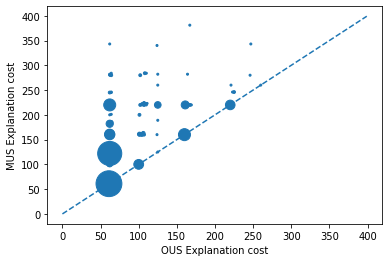

In [24]:
# processing the results
folder = '/home/crunchmonster/Documents/VUB/01_SharedProjects/03_resultsOUS/experiment5_qualitative/2021011617/'
files = list_json_dir(folder)
json_files = [read_json(f) for f in files]
mus_json_files = [f for f in json_files if 'MUS-time' in f['results'].keys()]
ous_json_files = [f for f in json_files if f not in mus_json_files]
musCosts = extractCosts(mus_json_files)
ousCosts = extractCosts(ous_json_files)

plotCosts(ousCosts, musCosts, (5, 4), coeff_thick=4)

# Experiment6

For every puzzle get the explanation sequence fastest result

folder = 

In [53]:
# MUS

musFolder = '/home/crunchmonster/Documents/VUB/01_SharedProjects/03_resultsOUS/experiment5/2021011809/'
instances = set(read_json(f)['config']['instance'] for f in list_json_dir(musFolder))
musFiles = [read_json(f) for f in list_json_dir(musFolder)]
musResults = musTimes(musFiles, instances)

# # cOUS
cOUSnonIncrFolder = '/home/crunchmonster/Documents/VUB/01_SharedProjects/03_resultsOUS/experiment6_cous/20210117'
cOUSNonIncrFiles = [read_json(f) for f in list_json_dir(cOUSnonIncrFolder)]
cOUSNonIncrResults, cOUSNonIncrconfigs = jsonToBest(cOUSNonIncrFiles, instances)
#print(cOUSNonIncrconfigs)

cOUSIncrFolder = '/home/crunchmonster/Documents/VUB/01_SharedProjects/03_resultsOUS/experiment4'
cOUSIncrFiles = [read_json(f) for f in list_json_dir(cOUSIncrFolder)]
cOUSIncrResults, cOUSIncrResultsconfigs = jsonToBest(cOUSIncrFiles, instances)
# print(cOUSIncrResultsconfigs)
 
# # Greedy
greedyFolder = '/home/crunchmonster/Documents/VUB/01_SharedProjects/03_resultsOUS/experiment6_greedy/20210117/'
greedyFiles = [read_json(f) for f in list_json_dir(greedyFolder) if f.stat().st_size > 5]
greedyIncrResults, greedyNonIncrResults, greedyIncrConfigs, greedyNonIncrConfigs = greedyJsonToBest(greedyFiles, instances)

print(greedyNonIncrConfigs)

colRenaming={
    'p20':6, 
    'p93':8, 
    'pastaPuzzle':'p', 
    'p16':2, 
    'p25':7, 
    'origin-problem':1, 
    'p18':4, 
    'p13':10, 
    'p12':3,
    'p19':5
}

# seperate in Incremental and non-incremental

dictResults = {
    'puzzles': [k for k in instances],
    'p': [colRenaming[k] for k in instances],
    'MUS-based': [0 for k in instances],
    'OUS non-incr': [0 for k in instances],
    'OUS incr': [0 for k in instances],
    'cOUS non-incr': [0 for  k in  instances],
    'cOUS + incr':[0 for k in instances]
}

fillDictResults(dictResults, musResults, 'MUS-based')
fillDictResults(dictResults, greedyNonIncrResults, 'OUS non-incr')
fillDictResults(dictResults, greedyIncrResults, 'OUS incr')
fillDictResults(dictResults, cOUSNonIncrResults, 'cOUS non-incr')
fillDictResults(dictResults, cOUSIncrResults, 'cOUS + incr')

# replace 7200 by timeout!
dictResultsReplaced = {}
for k, v in dictResults.items():
    dictResultsReplaced[str(k)] = [str(vi) if vi != 7200 else 'T.O.' for vi in v]

    
display(pd.DataFrame(dictResultsReplaced))
dfExp6 = pd.DataFrame(dictResultsReplaced)[['p', 'MUS-based', 'OUS non-incr', 'OUS incr', 'cOUS non-incr', 'cOUS + incr']]
dfExp6 = dfExp6.sort_values(by='p')
display(dfExp6)

tx = dfExp6.to_latex(
    bold_rows=True,
    index=False, 
    column_format='|r||c|c|c|c|c|c|',
    caption="Execution time compared between executions")
print(tx.replace('\\toprule', '\hline')
      .replace('\midrule', '\hline')
      .replace('\\bottomrule', '\hline')
      .replace('{table}', '{table*}')
     )

{'pastaPuzzle': {'preseeding': False, 'sat-polarity': False, 'sat-polarity-initial': False, 'postpone_opt': False, 'postpone_opt_incr': False, 'postpone_opt_greedy': False, 'grow': True, 'grow_sat': False, 'grow_subset_maximal': False, 'grow_maxsat': True, 'maxsat_polarities': True, 'grow_maxsat_full_pos': False, 'grow_maxsat_full_inv': False, 'grow_maxsat_full_unif': False, 'grow_maxsat_initial_pos': False, 'grow_maxsat_initial_inv': False, 'grow_maxsat_initial_unif': False, 'grow_maxsat_actual_pos': False, 'grow_maxsat_actual_unif': True, 'grow_maxsat_actual_inv': False, 'timeout': 7200, 'instance': 'pastaPuzzle', 'output': '/data/brussel/101/vsc10143/OUSResults/experiment6_greedy/2021011816/20210118165156809317.json', 'reuse_SSes': False, 'sort_literals': True}, 'p25': {'preseeding': True, 'sat-polarity': False, 'sat-polarity-initial': False, 'postpone_opt': False, 'postpone_opt_incr': False, 'postpone_opt_greedy': False, 'grow': True, 'grow_sat': False, 'grow_subset_maximal': False

,puzzles,p,MUS-based,OUS non-incr,OUS incr,cOUS non-incr,cOUS + incr
0,pastaPuzzle,p,224,2601,2528,618,651
1,p25,7,372,4411,4380,685,414
2,p93,8,474,4679,5552,669,448
3,p19,5,3382,T.O.,T.O.,3556,1537
4,origin-problem,1,569,4114,4727,803,299
5,p13,10,766,T.O.,T.O.,2383,1135
6,p18,4,624,3508,4820,388,97
7,p12,3,477,4220,4938,932,607
8,p16,2,438,3834,3972,607,238
9,p20,6,568,3849,3854,498,155


,p,MUS-based,OUS non-incr,OUS incr,cOUS non-incr,cOUS + incr
4,1,569,4114,4727,803,299
5,10,766,T.O.,T.O.,2383,1135
8,2,438,3834,3972,607,238
7,3,477,4220,4938,932,607
6,4,624,3508,4820,388,97
3,5,3382,T.O.,T.O.,3556,1537
9,6,568,3849,3854,498,155
1,7,372,4411,4380,685,414
2,8,474,4679,5552,669,448
0,p,224,2601,2528,618,651


\begin{table*}
\centering
\caption{Execution time compared between executions}
\begin{tabular}{|r||c|c|c|c|c|c|}
\hline
  p & MUS-based & OUS non-incr & OUS incr & cOUS non-incr & cOUS + incr \\
\hline
  1 &       569 &         4114 &     4727 &           803 &         299 \\
 10 &       766 &         T.O. &     T.O. &          2383 &        1135 \\
  2 &       438 &         3834 &     3972 &           607 &         238 \\
  3 &       477 &         4220 &     4938 &           932 &         607 \\
  4 &       624 &         3508 &     4820 &           388 &          97 \\
  5 &      3382 &         T.O. &     T.O. &          3556 &        1537 \\
  6 &       568 &         3849 &     3854 &           498 &         155 \\
  7 &       372 &         4411 &     4380 &           685 &         414 \\
  8 &       474 &         4679 &     5552 &           669 &         448 \\
  p &       224 &         2601 &     2528 &           618 &         651 \\
\hline
\end{tabular}
\end{table*}



In [26]:
cOUSnonIncrFolder = '/home/crunchmonster/Documents/VUB/01_SharedProjects/03_resultsOUS/experiment6_cous/20210117'
cOUSNonIncrFiles = [(f, read_json(f)) for f in list_json_dir(cOUSnonIncrFolder)]
print(cOUSNonIncrFiles)


cOUSIncrFolderExp6Bis = '/home/crunchmonster/Documents/VUB/01_SharedProjects/03_resultsOUS/experiment4'
cOUSIncrFilesExp6Bis = [read_json(f) for f in list_json_dir(cOUSIncrFolderExp6Bis)]
bestPreseedingOff, bestPreseedingOn = bestPreseedingOffOn(cOUSIncrFilesExp6Bis, instances)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [27]:
print(bestPreseedingOff)

{'pastaPuzzle': 651, 'p25': 414, 'p93': 448, 'p19': 1537, 'origin-problem': 299, 'p13': 1135, 'p18': 97, 'p12': 607, 'p16': 238, 'p20': 155}


In [28]:
print(bestPreseedingOn)

{'pastaPuzzle': 528, 'p25': 446, 'p93': 521, 'p19': 2220, 'origin-problem': 310, 'p13': 1359, 'p18': 112, 'p12': 662, 'p16': 250, 'p20': 146}


# RQ4 - Which domain-specific grow methods perform best?

In [72]:
def cactusGrouped(df,title="cumul-ous", fact='cumul-ous', groupKeys=[]):
    import random
    if len(groupKeys) == 0:
        groupKeys = ["grow_subset_maximal","grow_maxsat_actual_pos", "grow_maxsat_actual_unif", "grow_maxsat_actual_inv", "grow_maxsat_full_pos", "grow_maxsat_full_inv", "grow_maxsat_full_unif"]
    dfgrouped = df.groupby(by=groupKeys)[fact].apply(list).reset_index(name=fact)
    dfgrouped[fact] = dfgrouped[fact] \
                                .apply(lambda x: sorted(reduce(lambda a,b: a + b, x))) \
                                .apply(lambda x: list(filter(lambda elem: elem > 0, x)))
    mapping = {
        'grow_maxsat_full_pos': 'full+pos',
        'grow_maxsat_full_inv': 'full+inv',
        'grow_maxsat_full_unif': 'full+unif',
        'grow_maxsat_actual_pos': 'actual+pos',
        'grow_maxsat_actual_unif': 'actual+unif',
        'grow_maxsat_actual_inv': 'actual+inv',
        'grow_subset_maximal':'subset-max'
    }
    
    dfgrouped['config'] = dfgrouped.apply(
        lambda x: reduce(lambda a, b: a + (mapping[b] if x[b] else ''), [field for field in groupKeys if field not in [fact] and x[field]] , ""),
        axis = 1
    )
    dfgrouped['x'] = dfgrouped.apply(lambda x: list(range(len(x[fact])) ), axis=1 )
    dfgrouped['len'] = dfgrouped.apply(lambda x: len(x[fact]), axis=1 )
    dfgrouped.sort_values(by ='len', ascending=False)
    display(dfgrouped[['x','cumul-ous']])
#     plt.figure(figsize=(20,10))
    mStyles = [".",",","v","^","<",">","*","h","H","+","x"]
    random.shuffle(mStyles)
    for ((i, row), marker) in zip(dfgrouped.sort_values(by ='len', ascending=False).iterrows(), mStyles):
        plt.plot(row['x'], row[fact], label=row['config'], marker=marker)
    plt.legend()
    plt.xlabel('Explanation steps')
    plt.xlim((0, 1600))
    plt.ylabel('CPU time (s)')
#     plt.title(title, fontsize=12)
    plt.grid(True)
    plt.savefig('/home/crunchmonster/Desktop/figs/experiment4'+ datetime.now().strftime("%Y%m%d%H%M%S%f.png"), optimize=True, bbox_inches='tight')
    plt.savefig('/home/crunchmonster/Documents/VUB/01_SharedProjects/03_holygrail/latex/conferences/ijcai21/figures/'+ "rq4.png", optimize=True, bbox_inches='tight')
    plt.savefig('/home/crunchmonster/Documents/VUB/01_SharedProjects/03_holygrail/latex/conferences/ijcai21/figures/'+ "rq4.jpg", optimize=True, bbox_inches='tight')
    plt.savefig('/home/crunchmonster/Documents/VUB/01_SharedProjects/03_holygrail/latex/conferences/ijcai21/figures/'+ "rq4.pdf", bbox_inches='tight')
    plt.show()

In [44]:
# processing files
exp4folder = '/home/crunchmonster/Documents/VUB/01_SharedProjects/03_resultsOUS/experiment4'
growExp4Files = [read_json(f) for f in list_json_dir(exp4folder)]
dictexp4grow = jsonFilesToPandasDF(growExp4Files)



pd_dict = {}
for f_json in growExp4Files:
    for k, v in f_json['config'].items():
        if k == 'timeout' or k == 'disableConstrained':
            continue
        if k not in pd_dict:
            pd_dict[k] = []
        pd_dict[k].append(v)
    for k, v in f_json['results'].items():
        
        if k not in pd_dict:
            pd_dict[k] = []
        pd_dict[k].append(v)

dfgrowExp4new = pd.DataFrame(pd_dict)
dfgrowExp4newNoTimeout = dfgrowExp4new
dfgrowExp4newNoTimeout['totTime'] = dfgrowExp4newNoTimeout.apply(lambda row: sum(row["OUS-time"]), axis=1)
dfgrowExp4newNoTimeout['cumul-ous'] = dfgrowExp4newNoTimeout.apply(
    lambda row: [sum(row["OUS-time"][:i]) for i in range(1, len(row["OUS-time"])+1)] , axis=1)
dfgrowExp4newNoTimeout['cumul-ous'] = dfgrowExp4newNoTimeout.apply(lambda row: row["cumul-ous"]+[7200] if row["timeout"] else row["cumul-ous"], axis=1)


['timedout', 'config', 'cumul-ous', 'cumul-sat', 'cumul-post', 'cumul-opt', 'cumul-HS', 'cumul-HS-all', 'totTime', 'timeToFirst', 'First-Tot', 'fname', 'created', 'maxsat_polarities', 'disableConstrained', 'preseeding', 'sat-polarity', 'sat-polarity-initial', 'postpone_opt', 'postpone_opt_incr', 'postpone_opt_greedy', 'grow', 'grow_sat', 'grow_subset_maximal', 'grow_maxsat', 'grow_maxsat_full_pos', 'grow_maxsat_full_inv', 'grow_maxsat_full_unif', 'grow_maxsat_initial_pos', 'grow_maxsat_initial_inv', 'grow_maxsat_initial_unif', 'grow_maxsat_actual_pos', 'grow_maxsat_actual_unif', 'grow_maxsat_actual_inv', 'timeout', 'instance', 'output', 'HS', 'HS_greedy', 'HS_incr', 'HS-opt-time', 'HS-postpone-time', 'SAT-time', 'grow-time', '#expl', 'expl_seq', 'OUS-time']


,x,cumul-ous
0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.24194741249084473, 0.24575185775756836, 11...."
1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.2959301471710205, 0.29935264587402344, 7.71..."
2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.006383419036865234, 0.006383419036865234, 1..."
3,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.5283381938934326, 0.5345687866210938, 2.919..."
4,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.003930091857910156, 1.8328213691711426, 2.6..."
5,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.004606485366821289, 0.12403678894042969, 1...."
6,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.003268003463745117, 1.7140898704528809, 1.7..."


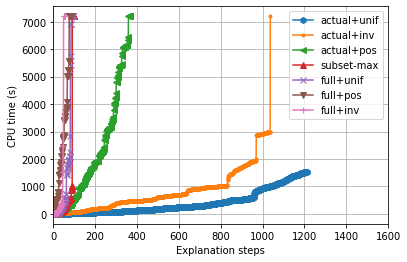

In [45]:

# keeping the best-execution

print(list(dictexp4grow))
dfexp4grow = pd.DataFrame(dictexp4grow)
dfexp4grow = dfgrowExp4newNoTimeout
# dfexp4grow['totTime'] = dfexp4grow.apply(lambda row: sum(row["OUS-time"]), axis=1)

# selecting correct attributes
# preseeding = False
# postponing optmisation = False
# grow = true
# maxsat grow = True
 # not equal to initial
dfexp4growFiltered = dfexp4grow[
    
    (dfexp4grow["postpone_opt"] == False)& 
    (dfexp4grow["grow_maxsat"] == True) & 
    (
        (dfexp4grow['grow_maxsat_actual_pos'] == True) | 
        (dfexp4grow['grow_maxsat_actual_unif'] == True) |
        (dfexp4grow['grow_maxsat_actual_inv'] == True) |
        (dfexp4grow['grow_maxsat_full_pos'] == True) |
        (dfexp4grow['grow_maxsat_full_inv'] == True) |
        (dfexp4grow['grow_maxsat_full_unif'] == True)
    )]

dfexp4growFilter = dfexp4grow[(dfexp4grow['grow_subset_maximal'] == True)]
# comment line here if subset max disabled
dfexp4growFiltered = dfexp4growFiltered.append(dfexp4growFilter, ignore_index=True)

selectedConfigFilters= ["instance","grow_subset_maximal", "grow_maxsat", "grow_maxsat_actual_pos", "grow_maxsat_actual_unif", "grow_maxsat_actual_inv", "grow_maxsat_full_pos", "grow_maxsat_full_inv", "grow_maxsat_full_unif"]

dfexp4growFiltered = dfexp4growFiltered.loc[dfexp4growFiltered.groupby(by=selectedConfigFilters)["totTime"].idxmin()]
#display(dfexp4growFiltered)

# display(dfexp4growFiltered)

cactusGrouped(dfexp4growFiltered, fact='cumul-ous')

In [113]:
def jsonFilesToExtendedDf(jsonFiles, greedy=False):
    pd_dict = {}
    for f_json in jsonFiles:
        if greedy:
            soutime = []
            for subl in f_json['results']["OUS-time"]:
                soutime.append([t for t in subl if t > 0])
        else:
            f_json['results']["OUS-time"] = [t for t in f_json['results']["OUS-time"] if t > 0]
        for k, v in f_json['config'].items():
            if k == 'timeout' or k == 'disableConstrained':
                continue
            if k not in pd_dict:
                pd_dict[k] = []
            pd_dict[k].append(v)
        for k, v in f_json['results'].items():
            if 'totTime' == k:
                continue

            if k not in pd_dict:
                pd_dict[k] = []
            pd_dict[k].append(v)
            
    # making sure all values are of same lengt
    notgood = False
    for k, v in pd_dict.items():
        if len(pd_dict['grow']) != len(v):
            print(k, len(v))
            notgood = True
    if notgood:
        raise "k,v error"
    df = pd.DataFrame(pd_dict)
    
    if greedy:
        df['totTime'] = df.apply(lambda row: sum(sum(subl) for subl in row["OUS-time"]), axis=1)
    else:
        df['totTime'] = df.apply(lambda row: sum(row["OUS-time"]), axis=1)
        
    df['totTime'] = df.apply(lambda row: 7200 if row["timeout"] else row['totTime'], axis=1)
    if greedy:
        df['cumul-ous'] = df.apply(lambda row: [sum(sum(subl) for subl in row["OUS-time"][:i]) for i in range(1, len(row["OUS-time"])+1)] , axis=1)
    else:
        df['cumul-ous'] = df.apply(lambda row: [sum(row["OUS-time"][:i]) for i in range(1, len(row["OUS-time"])+1)] , axis=1)
    df['cumul-ous'] = df.apply(lambda row: row["cumul-ous"]+[7200] if row["timeout"] else row["cumul-ous"], axis=1)
    
    return df

def folderToDf(folder, greedy=False):
    files = [read_json(f) for f in list_json_dir(folder) if f.stat().st_size > 5]
    df = jsonFilesToExtendedDf(files, greedy)
    return df

In [137]:
# processing files
cOUSnonIncrFolder = '/home/crunchmonster/Documents/VUB/01_SharedProjects/03_resultsOUS/experiment6_cous/20210117'
dfcOUSnonIncr = folderToDf(cOUSnonIncrFolder)
dfcOUSnonIncrFiltered = dfcOUSnonIncr[
    (dfcOUSnonIncr["postpone_opt"] == False)&
    (dfcOUSnonIncr["grow_maxsat"] == True) & 
    (dfcOUSnonIncr['grow_maxsat_actual_unif'] == True)]

cOUSIncrFolder = '/home/crunchmonster/Documents/VUB/01_SharedProjects/03_resultsOUS/experiment4'
dfcOUSIncr = folderToDf(cOUSIncrFolder)
dfcOUSIncrFiltered = dfcOUSIncr[
    (dfcOUSIncr["postpone_opt"] == False)&
    (dfcOUSIncr["grow_maxsat"] == True) & 
    (dfcOUSIncr['grow_maxsat_actual_unif'] == True)]

greedyFolder = '/home/crunchmonster/Documents/VUB/01_SharedProjects/03_resultsOUS/experiment6_greedy/20210117/'
dfGreedy = folderToDf(greedyFolder, True)
dfGreedyFiltered = dfGreedy[
    (dfGreedy["postpone_opt"] == False)&
    (dfGreedy["grow_maxsat"] == True) & 
    (dfGreedy['grow_maxsat_actual_unif'] == True)]

In [138]:
# selected config filters
selectedcOUSConfigFilters= ["instance","grow_maxsat_actual_unif"]
selectedColumns = ["instance", "cumul-ous", "totTime"]

dfcOUSnonIncrFiltered = dfcOUSnonIncrFiltered.loc[dfcOUSnonIncrFiltered.groupby(by=selectedcOUSConfigFilters)["totTime"].idxmin()]
dfcOUSnonIncrFiltered = dfcOUSnonIncrFiltered[selectedColumns]
dfcOUSnonIncrFiltered['config'] = dfcOUSnonIncrFiltered.apply(lambda x: "OCUS", axis=1)

dfcOUSIncrFiltered = dfcOUSIncrFiltered.loc[dfcOUSIncrFiltered.groupby(by=selectedcOUSConfigFilters)["totTime"].idxmin()]
dfcOUSIncrFiltered = dfcOUSIncrFiltered[selectedColumns]
dfcOUSIncrFiltered['config'] = dfcOUSIncrFiltered.apply(lambda x: "OCUS+I", axis=1)

selectedgreedyConfigFilters= ["reuse_SSes", "instance", "grow_maxsat_actual_unif"]
dfGreedyFiltered = dfGreedyFiltered.loc[dfGreedyFiltered.groupby(by=selectedgreedyConfigFilters)["totTime"].idxmin()]

dfGreedyFilteredNonIncr = dfGreedyFiltered[dfGreedyFiltered["reuse_SSes"] == False][selectedColumns]
dfGreedyFilteredIncr = dfGreedyFiltered[dfGreedyFiltered["reuse_SSes"] == True][selectedColumns]
dfGreedyFilteredNonIncr['config'] = dfGreedyFilteredNonIncr.apply(lambda x: "OUS", axis=1)
dfGreedyFilteredIncr['config'] = dfGreedyFilteredIncr.apply(lambda x: "OUS+I", axis=1)

dfAllConfigs = dfcOUSnonIncrFiltered.append([dfcOUSIncrFiltered, dfGreedyFilteredNonIncr, dfGreedyFilteredIncr])

In [136]:
def cactusGrouped2(df,title="cumul-ous", fact='cumul-ous', groupKeys=[]):
    import random
    if len(groupKeys) == 0:
        groupKeys = ["grow_subset_maximal","grow_maxsat_actual_pos", "grow_maxsat_actual_unif", "grow_maxsat_actual_inv", "grow_maxsat_full_pos", "grow_maxsat_full_inv", "grow_maxsat_full_unif"]
    dfgrouped = df.groupby(by=groupKeys)[fact].apply(list).reset_index(name=fact)
    dfgrouped[fact] = dfgrouped[fact] \
                                .apply(lambda x: sorted(reduce(lambda a,b: a + b, x))) \
                                .apply(lambda x: list(filter(lambda elem: elem > 0, x)))
   
    dfgrouped['x'] = dfgrouped.apply(lambda x: list(range(len(x[fact])) ), axis=1 )
    dfgrouped['len'] = dfgrouped.apply(lambda x: len(x[fact]), axis=1 )
    dfgrouped.sort_values(by ='len', ascending=False)
    display(dfgrouped[['x','cumul-ous']])
#     plt.figure(figsize=(20,10))
    mStyles = ["1","+","x"] * 4
    random.shuffle(mStyles)
    for ((i, row), marker) in zip(dfgrouped.sort_values(by ='len', ascending=False).iterrows(), mStyles):
        plt.plot(row['x'], row[fact], label=row['config'], marker=",")
    plt.legend()
    plt.xlabel('Explanation steps')
#     plt.xlim((0, 1600))
    plt.ylabel('CPU time (s)')
#     plt.title(title, fontsize=12)
    plt.grid(True)
    plt.savefig('/home/crunchmonster/Desktop/figs/experiment4'+ datetime.now().strftime("%Y%m%d%H%M%S%f.png"), optimize=True, bbox_inches='tight')
    plt.savefig('/home/crunchmonster/Documents/VUB/01_SharedProjects/03_holygrail/latex/conferences/ijcai21/figures/'+ "rq4.png", optimize=True, bbox_inches='tight')
    plt.savefig('/home/crunchmonster/Documents/VUB/01_SharedProjects/03_holygrail/latex/conferences/ijcai21/figures/'+ "rq4.jpg", optimize=True, bbox_inches='tight')
    plt.savefig('/home/crunchmonster/Documents/VUB/01_SharedProjects/03_holygrail/latex/conferences/ijcai21/figures/'+ "rq4.pdf", bbox_inches='tight')
    plt.show()

In [ ]:

cactusGrouped2(dfAllConfigs, fact='cumul-ous', groupKeys=["config"])

,x,cumul-ous
0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.008920907974243164, 0.5896859169006348, 1.3..."
1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.003930091857910156, 1.8328213691711426, 2.6..."
2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[45.562358379364014, 66.95311498641968, 76.621..."
3,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[35.1514208316803, 51.169804096221924, 57.2781..."
